# What's really going on in PBjam - an advanced tutorial

## Introduction

PBjam is a code for 'peakbagging' solar-like oscillations.  The code has been designed to provide automated peakbagging data analysis relying on probablilistic methods.  The aim is to achieve a peakbagging code that will work, and not just on high signal-to-noise targets but also on lower signal-to-noise examples.  We aim to achieve a code that works on a wide variety of solar-like oscillations including main sequence, sub giant, and red giant stars.  And we aim to provide all this functionality in an easy to use interface that requires little user expertise.

The current state of PBjam reflects it's developmental nature.  Currently functionality is provided for peakbagging radial and quadrupole modes.  Additional functionality for dipole and octupole modes is under developement and will be released as part of version 2.0. 

In this example we will demonstrate what is happening under the hood of PBjam.  As such this consititutes an advanced tutorial that relies somewhat on basic knowledge of solar-like peakbagging and it's terminology.  There are many resouces in the scientific literature if the user requires more background (link Guy, Martin papers, Bill & Sabani's book (its a really excellent introduction)). 

This example will look at a high signal-to-noise ratio red giant with nearly 4 years of high quality Kepler data (KIC 4448777).  We will use the excellent Lightkurve tool to handle the data and refer the user to the excellent [Lightkurve docs](https://www.docs.lightkurve.org) for details and functionality.

In [1]:
import pbjam as pb
import lightkurve as lk 

KIC 4448777 has already been extensively studied and the interested reader can find more [here](https://ui.adsabs.harvard.edu/abs/2016ApJ...817...65D/abstract).  Table 2 of this work lists mode frequencies that we can use as a comparison with our results later.

## Setup

We start by setting up the exisiting knowledge of the star.  We take exisiting values of $\nu_{\rm max}$, $\Delta {\nu}$, Teff, and Gaia $G_{\rm bp} - G_{\rm rp}$.  Each observable is set up as a tuple in the form (value, uncertainty).  

We will use all four of the observed quantities but PBjam can be run with some subset of the observables.  It is recommended that as an absolute minimum, at least $\nu_{\rm max}$ and $\Delta {\nu}$ should be provided for rediants and subgiants, while at least $\Delta {\nu}$ and Teff should be provided for main sequence stars.  PBjam will work best if all 4 observed properties are provided and the provided values are accurate.

In [2]:
kic = '4448777'
numax = (220.0, 3.0)  # in microhertz
dnu = (16.97, 0.05)   # in microhertz
teff = (4750, 250)    # in Kelvin
bp_rp = (1.34, 0.1)   # in mag

### Data collection and preparation

We handle all of our data in this tutorial using [lightkurve](https://docs.lightkurve.org/index.html).  First we download all available lightcurves:

In [3]:
lcs = lk.search_lightcurvefile(kic).download_all()

We then process the lightcurve collection by concatenating, normalizing, flattening, and the finally removing outliers:

In [4]:
lc = lcs[0].PDCSAP_FLUX.normalize().flatten(window_length=401)
for l in lcs[1:]:
    lc = lc.append(l.PDCSAP_FLUX.normalize().flatten(window_length=401))
lc = lc.remove_outliers(4)

Lightkurve provides plot functionality for it's lightcurve objects and so to plot the time series data we simply:

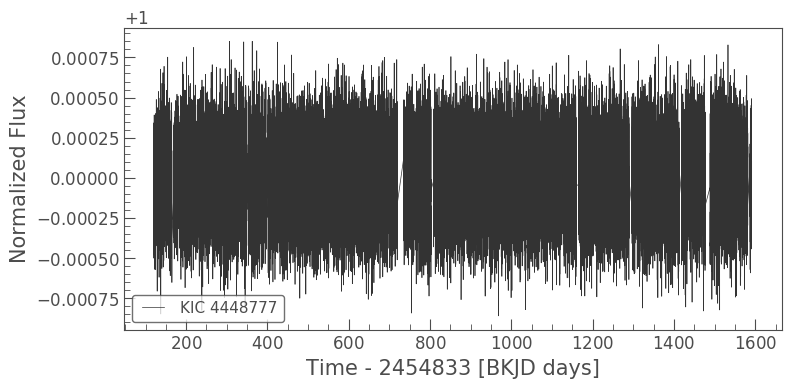

In [5]:
lc.plot();

We then use the lightkurve periodogram functionality to get a critically sampled power spectrum with frequency units of $\mu \rm Hz$ (i.e., normalization='psd').  We set the maximum and minimum frequency of the periodogram based on the estimated numax and dnu and finally we flatten the periodogram.

The flatten function uses lightkurves inbuilt method to remove the broadband background power but maintain the modes of oscillation.  The lightkurve method uses a simple estimation of the background based on a varying width median filter in log space, and divides the power by the estimated background to produce what is commonly referred to as a signal-to-noise spectrum.  The lightkurve implementation is less than optimal but fast and easy to use.  If you care about the treatment of the background and worry about it's impact on your results then you can implement your own method here (for example background fitting) to produce a flattened periodogram.

In [6]:
pg = lc.to_periodogram(normalization='psd', 
                      minimum_frequency=numax[0] - dnu[0] * 4,
                      maximum_frequency=numax[0] + dnu[0] * 4).flatten()

Again, a lightkurve periodogram has a plot function:

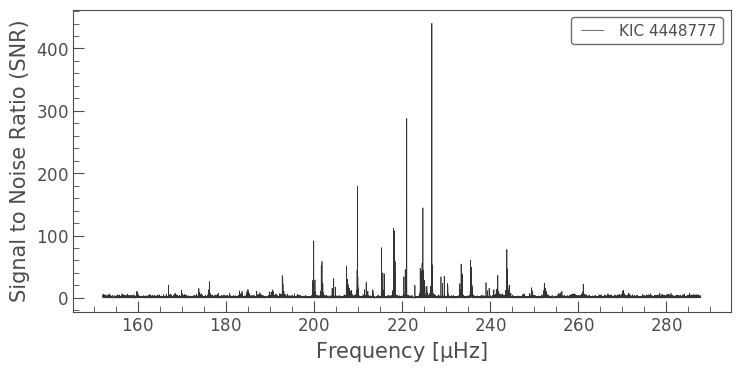

In [7]:
pg.plot()

At this stage our setup is complete.  We have some observed properties and we have some data.  We move on to using PBjam to try to understand and interpret the data we have.

## PBjam

### Motivation

Most of the effort in PBjam (both computational and developmental) is applied to determining mode degree identification given some periodogram.  For this task we break up what we know into two components:

\begin{align*}
P(M \, | \, D) \propto P(M) \, P(D \, | \, M),
\end{align*}

where $P(M \, | \, D)$ is the posterior probability of some model $M$ given the data $D$, $P(M)$ is the prior constraint on $M$, and $P(D \, | \, M)$ is the probability of $M$ given the data.  If we use a more informal syntax then the prior is what we know already, the likelihood tells us what we know from the data, and the posterior is what we care about: the combination of our exisiting knowledge and our new knowledge. 

For peakbagging solar-like oscillations we have a wealth of experience and exisiting knowledge.  The *Kepler* mission has provided excllent data sets for thousands of solar-like oscillators.  PBjam uses this exisiting data set to generate a prior probability function $P(M)$.  In PBjam we call the prior function `epsilon` because, well because.

For the likelihood function to provide a model to compare with the data, we use a simple asymptotic relation that describes the well established pattern of radial and quadrupole modes in the periodogram.  The pattern is not much more than the sum of regularly spaced Lorentzian profiles in addition to some background.  This pattern provides a simple model than can be used as $M$ and allows for the easy evaluation of $P(D \, | \, M)$.  We use `asy_peakbag` to estimate $P(M \, | \, D)$ and hence make a mode identification.

Once mode identification is complete, we perform the actual peakbagging using `peakbag`.  This peakbagging uses a new model and is powered by the NUTS sampler of [pymc3](https://docs.pymc.io/). Here we try to minimise the prior constraints from the previous steps leaking through into the fit.  But, there is a trade off between speed and stability vs minimum prior constraint.  We will discuss the priors in more detail in the `peakbag` section.

### `epsilon`

The prior function we build is a continuous function based on previously fitted solar-like oscillator examples.  There are many way of building a prior function but here we use a [Kernel Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) approach where previous results are used as input.  

A KDE is fundamentally a data smoothing problem and many uses will be familar with 1D KDE's.  Here we use a [multidimensional KDE](https://en.wikipedia.org/wiki/Multivariate_kernel_density_estimation) with a band width for each of the 10 dimensions we implement.  This gives full control over the degree of smoothing of the prior data.  The KDE is constructed as:

\begin{align*}
P(\mathbf x) \propto \frac{1}{n} \sum_{i=1}^{n} {\mathbf K_{\mathbf H}}({\mathbf x - \mathbf x_{i}}),
\end{align*}

where $\mathbf x$ are the input parameters, $\mathbf x_{i}$ is one of $n$ prior data points used to construct the prior.  $\mathbf K_{\mathrm H}$ is the band width matrix for which we use a multivariate Gaussian covariance matrix with all off-axis elemets set to zero (sometimes called a D-type kernel):

\begin{align*}
 {\mathbf K_{\mathbf H}} = (2 \pi)^{-d / 2} |\mathbf H|^{-1/2} \exp \left( -\frac{1}{2} \mathbf x^{T} \mathbf H ^{-1} \mathbf x\right),
\end{align*}

where $d$ is the number of dimensions of the multivariate KDE and we construct $\mathbf H$ as.

\begin{align*}
\mathbf H = {\mathrm{diag}(\mathbf \sigma)} \, \mathbf I \, {\mathrm{diag}(\mathbf \sigma)},
\end{align*}

where $\mathbf I$ is the $d \times d$ identity  matrix.

As a normalized probability density function it is straight forward, using MCMC sampling tools, to estimate the posterior distribution $P(M \, | \, D)$ given some set of observations on parameters of the KDE.  In `epsilon` we use [emcee](https://github.com/dfm/emcee) to sample the posterior distribution given some observations.

In PBjam we determine the optimal band width ($\sigma$) coefficients using a cross validated maximum likelihood approach.  This approach creates a smooth function that is largely insensitive in inidivdual data points.  The optimal band width will be larger when the density of prior data points less and vice versa.  As such the prior constraint priorvide by the KDE is expected to improve as we populate the prior with more robust examples of solar-like oscillations.  Note, to account for a larger spread in signal to noise examples in expected useage compared to the prior data we dramactially increase the band width values of the axis asscoiated with the signal-to-noise ratio.   

Background to one side, here is how to run `epsilon`.  We start with an instance of epsilon and the call this instance while passing in observables.

In [8]:
ep = pb.epsilon()
result = ep(dnu=dnu, numax=numax, teff=teff, bp_rp=bp_rp)

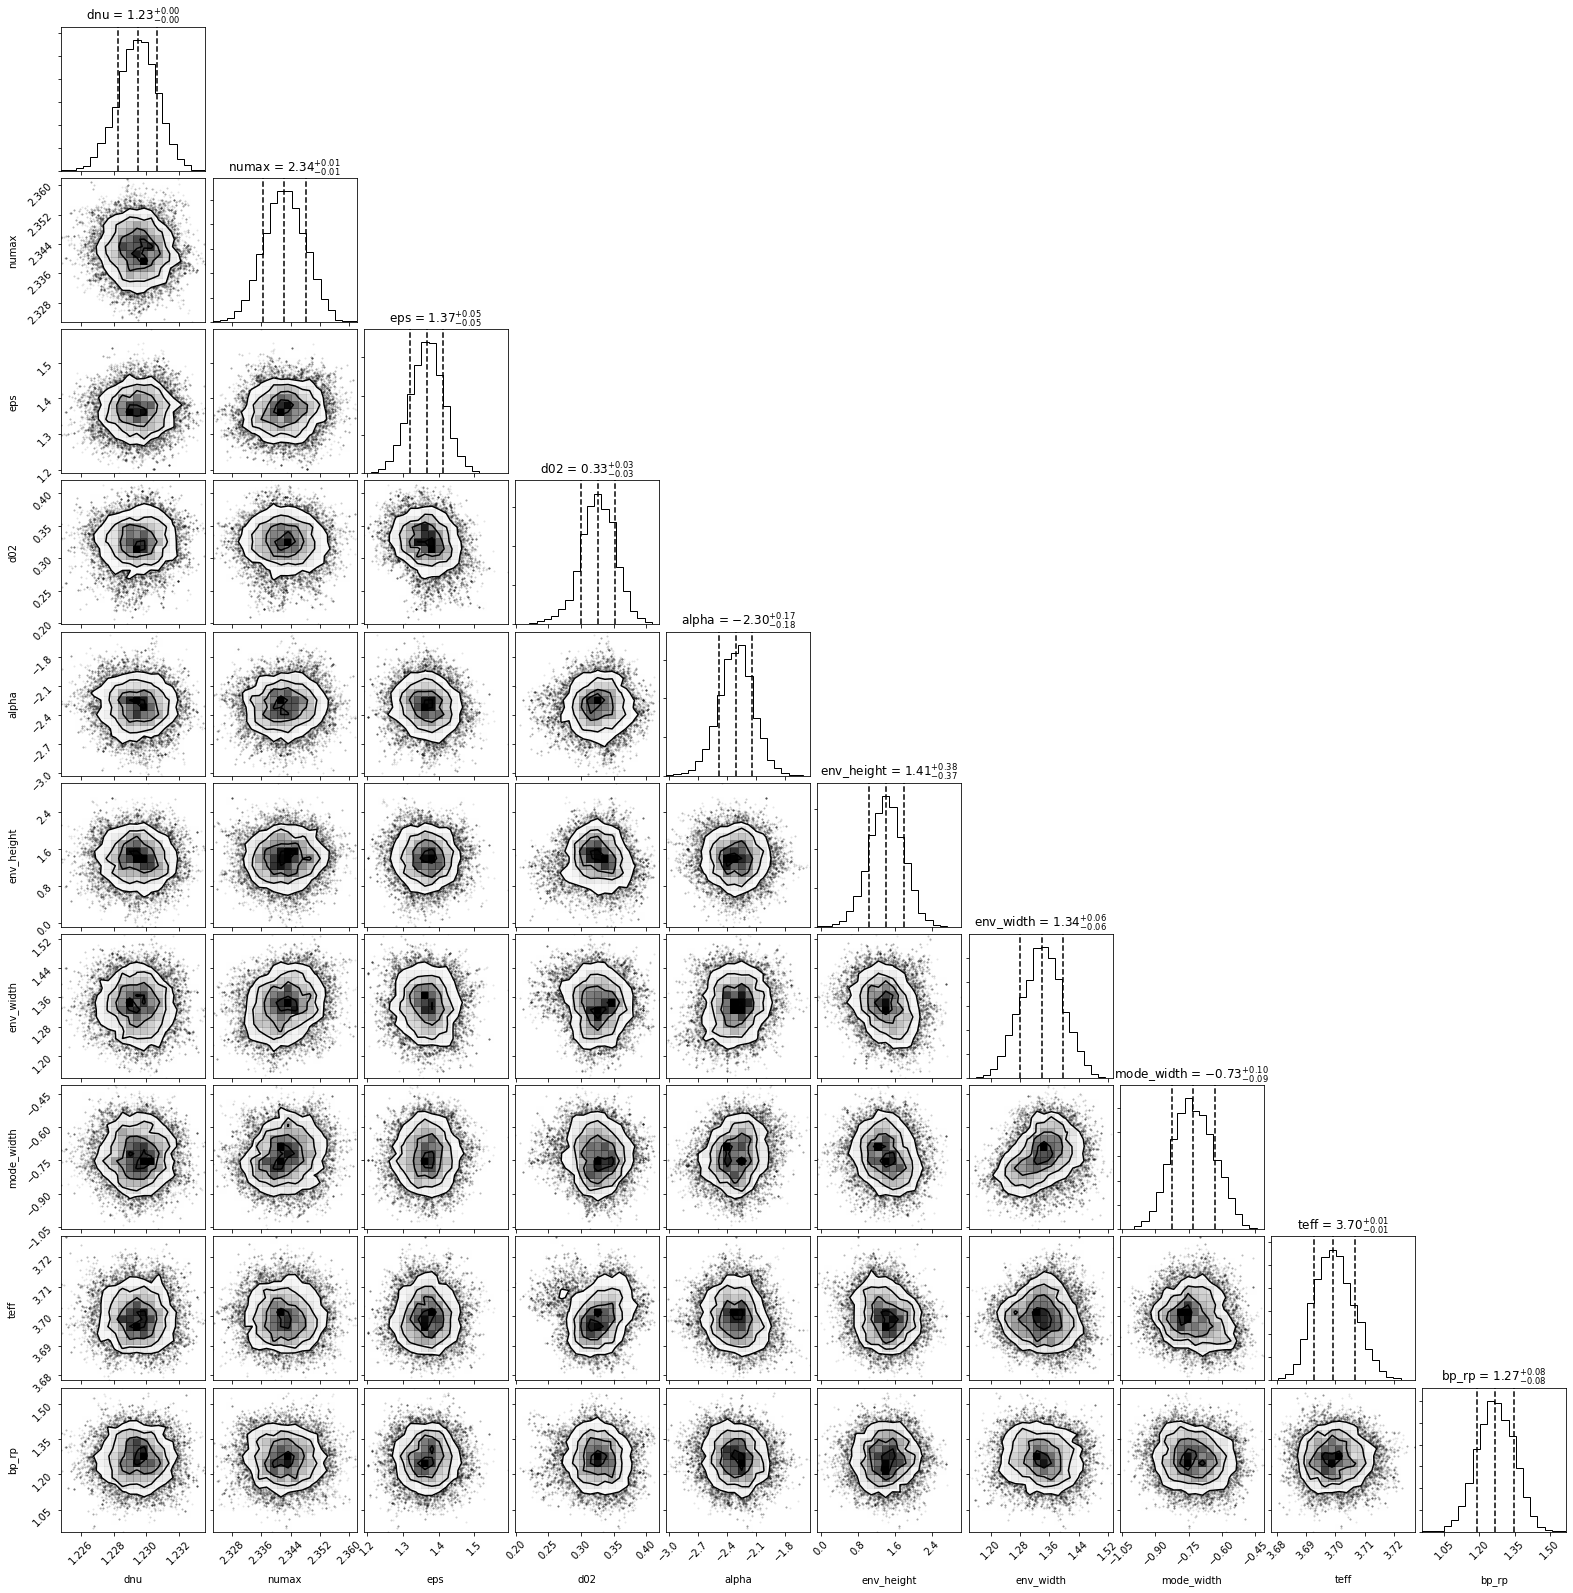

In [9]:
ep.plot_corner();

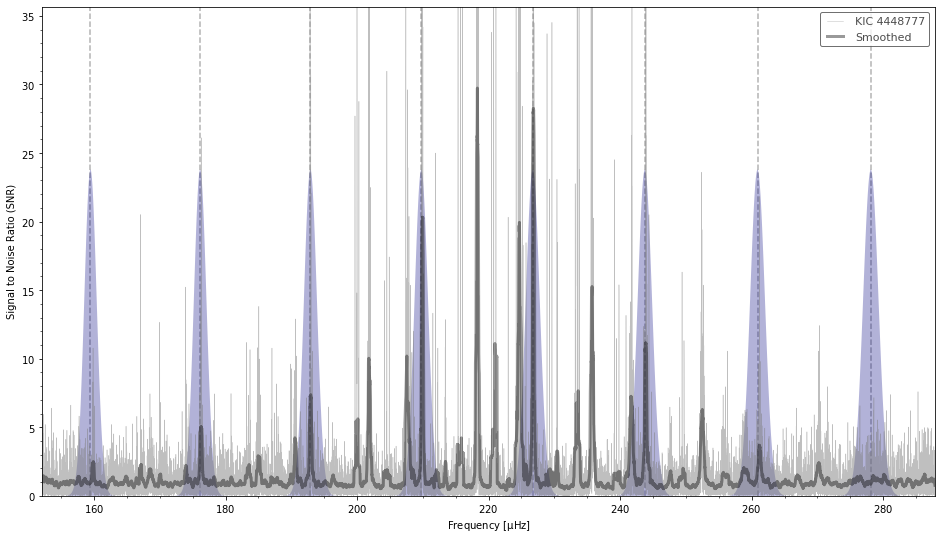

In [10]:
ep.plot(pg);

### `asy_peakbag`

In [11]:
asy = pb.asy_peakbag.asymptotic_fit(pg.frequency.value, pg.power.value, 
                                    ep.samples, 
                                    teff, bp_rp, 
                                    nthreads=1, norders=10,
                                    store_chains=True)

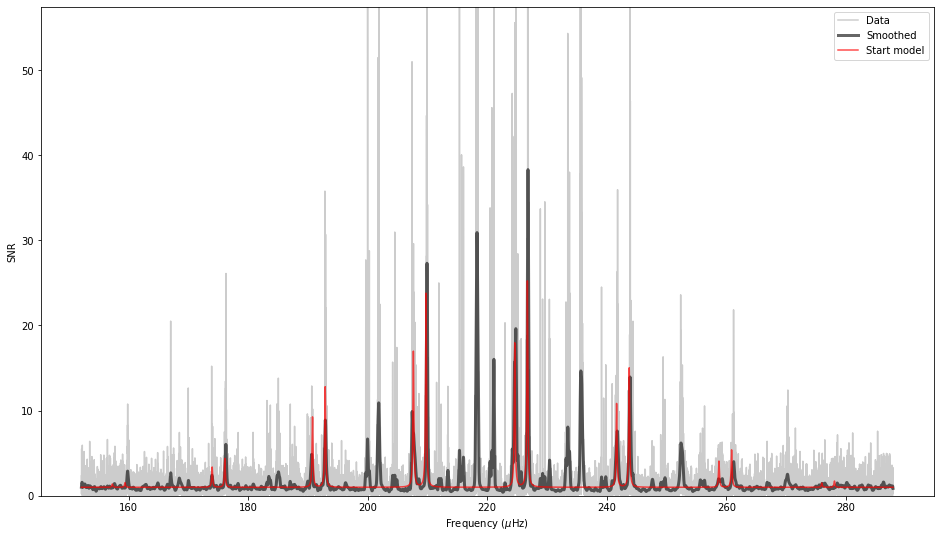

In [12]:
asy.plot_start();

In [13]:
asy_result = asy.run(burnin=1000, niter=1000)

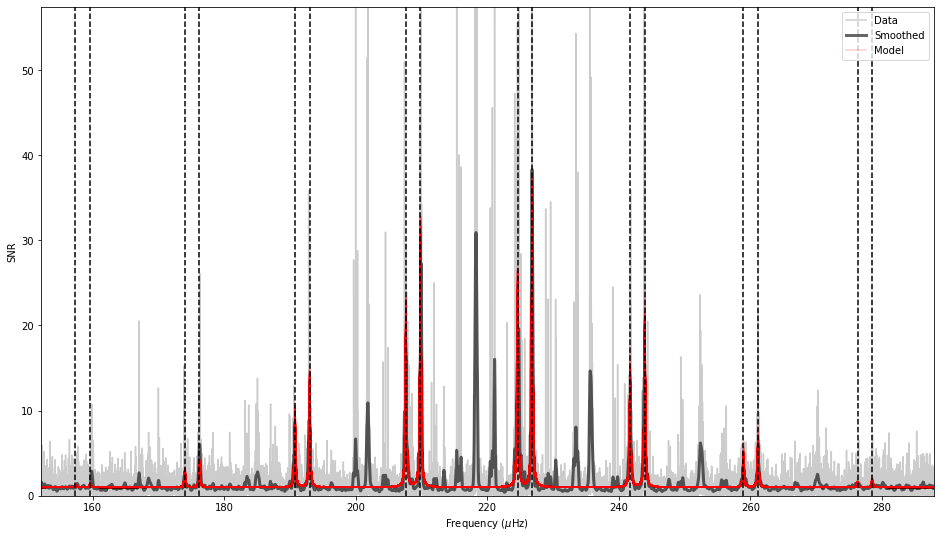

In [14]:
asy.plot();

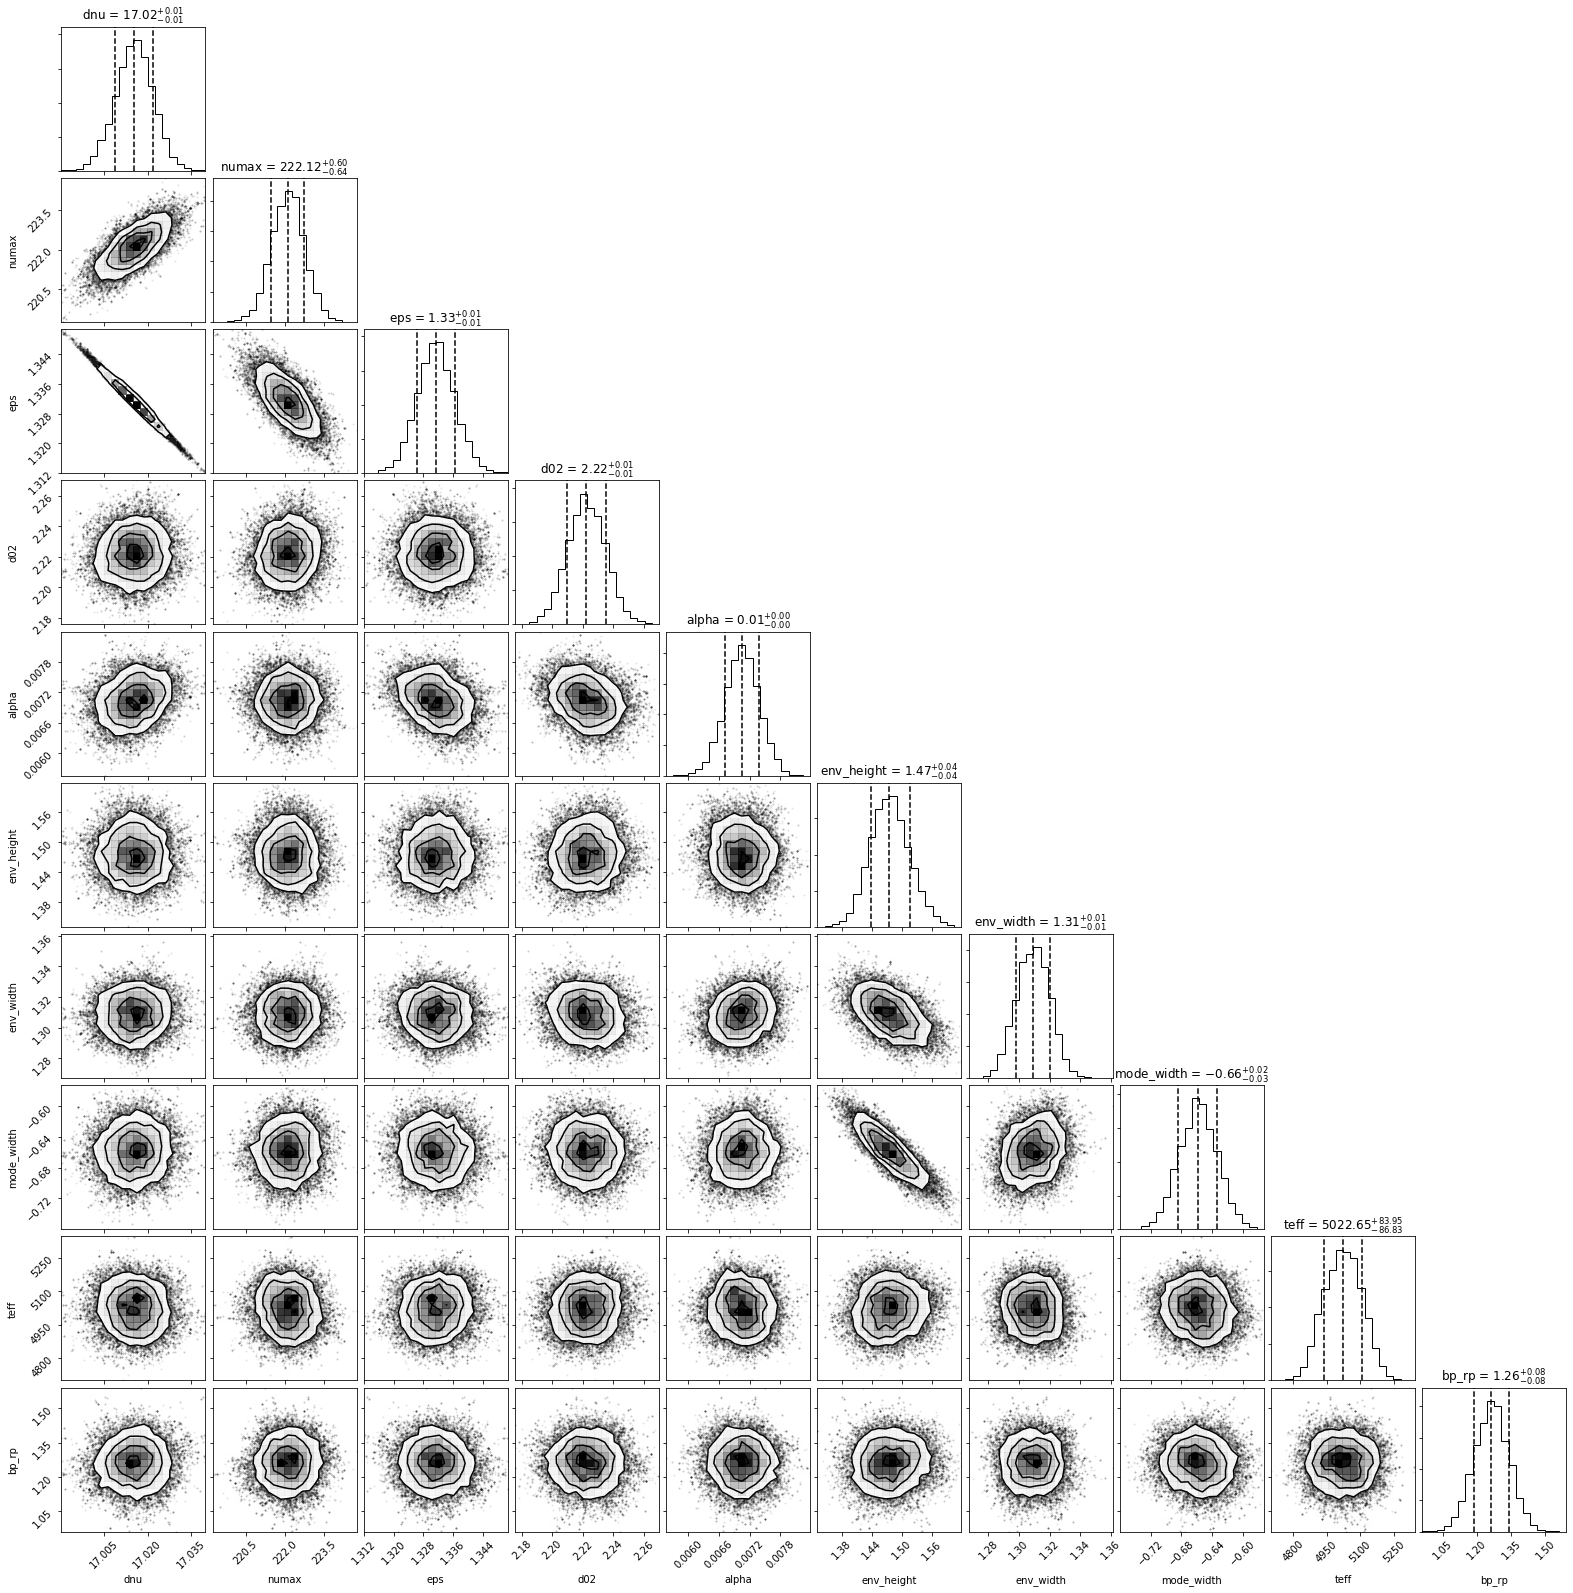

In [15]:
asy.plot_corner();

### `peakbag`

In [16]:
pbag = pb.peakbag(pg.frequency.value, pg.power.value, asy_result)

In [18]:
pbag.sample(model_type='simple', cores=4, tune=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [back, height2, height0, width2, width0, l2, l0]
Sampling 4 chains: 100%|██████████| 8000/8000 [01:08<00:00, 29.75draws/s] 


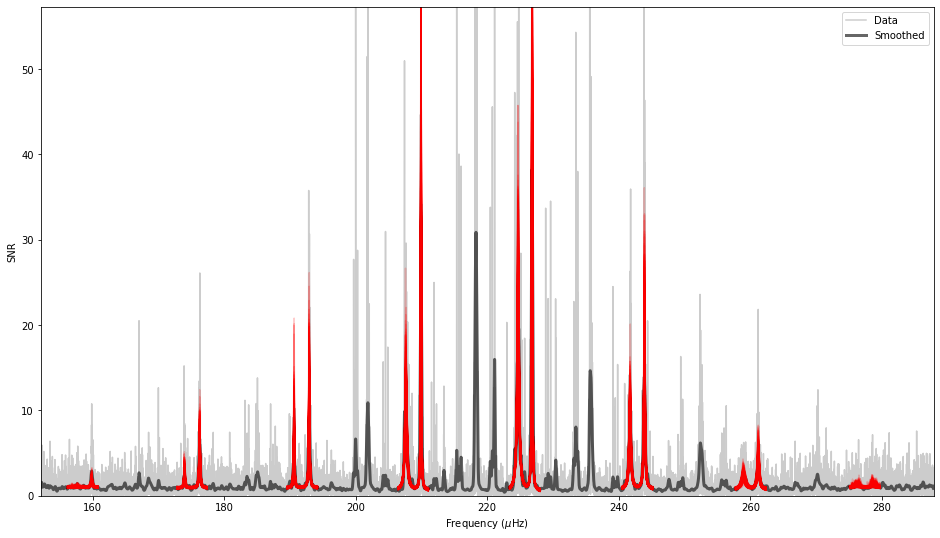

In [20]:
pbag.plot_flat_fit(thin=10);